## Introduction

The Titanic is now infamous as a shipwreck at the beginning of the 20th century. Many passengers lost their lives when the ship went down, cementing this as a tragic piece of history. We can attempt to understand what it was like in those final moments from the stories of those who survived, our exploration of the wreckage, and through our use of the records available to us. 

In this report, we will be focusing on an analysis of the passenger manifest to get a picture of who survived the wreck. The guiding question is "Who had a better chance of surviving the wreck?"

While our focus will be on the numbers, we should be aware that what we're building is a big picture understanding of what happened. We'll be accessing a story of tragedy through modern data-driven means. 

### Tools

Our tools will be the language Python and it's data analysis libraries. We'll make use of pandas, numpy, scipy and matplotlib (with seaborn).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations

%pylab inline
pylab.rcParams['figure.figsize'] = (8.0, 7.0)

titanic = pd.read_csv('titanic_data.csv')

alpha = 0.05

Populating the interactive namespace from numpy and matplotlib


Our alpha level for statistical tests will be set at 0.05 .

### The Dataset

The dataset originates from a learning competition on Kaggle, [*Titanic: Machine Learning from Disaster*](https://www.kaggle.com/c/titanic). Since this analysis is mainly exploratory, our focus is on the provided train.csv file and doesn't include test.csv. This dataset is already well-organized and formatted, and doesn't require much cleaning. 

Here's what the dataset looks like.

In [2]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print("The number of rows in the dataset:",len(titanic),".")

The number of rows in the dataset: 891 .


The variables of interest will be Survived, Pclass, Sex, Age, Parch, Fare. The values of some of these variables aren't entirely obvious. Survived is a binary entry denoting whether the passenger survived the ship wreck with 1 denoting survival. Pclass is the passenger class with 1st as the highest and 3rd as the lowest. Fare and Pclass can be used as a proxy for the wealth of the passenger. Parch is the number of parents/children aboard. Of the variables of interest for analysis, only Age has missing values. 

In [4]:
titanic.isnull().sum()[titanic.isnull().sum() > 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

Age is missing 177 values, which is a significant proportion of the 891 rows in the dataset. Given the other variables in the dataset, there doesn't seem to be any reliable way to estimate the age for passengers where it is missing. Thus we'll take the approach of omitting rows that contain a missing value for Age. This will either be handled explicitly prior to calculations by using the following filtered version of the dataframe, or implicitly in function calls which can be set to omit missing values (like in Pandas mean function). 

In [5]:
# The safe version of the dataframe to use when calculating with Age
titanic_safe = titanic[titanic['Age'].notnull()].copy()

### Predefined Functions

We'll be printing survival rates as proportions. To be able to properly put these in context, we'll also provide total counts along side those proportions. The following function cuts down on repetitious code.

In [6]:
# Takes in the dataframe grouped by some variables, returns the survival proporition alongside total counts.
def survival_rate_and_total(grouped_dataframe):
    return pd.concat([grouped_dataframe.mean(), grouped_dataframe.count()], axis=1, keys=['% Survived of Total', 'Total'])

We'll be using chi-squared tests to determine statistical significance. Also as post-hoc analysis, we'll make use of pairwise chi-squared tests for groups if the initial test determines significance. These pairwise tests' significance levels will use the Bonferroni correction, i.e. we'll divide our alpha of 0.05 by the number of pairwise comparisons. The following functions streamlines the chi-squared tests, pairwise comparisons and printing of the results.

In [7]:
# Takes the name of the column and values of the column to perform the test on
# Returns the result of scipy.stats.chisquare 
def chisquared(column, values, df = titanic):
    observed_survival = []
    expected_survival = []
    for value in values:
        observed_survival.append(df[df[column] == value]['Survived'].sum())
        expected_survival.append(df[df[column] == value]['Survived'].count() * baseline_survival)
    result = stats.chisquare(f_obs=observed_survival, f_exp=expected_survival)
    return result

# Takes the name of the column and the result of chisquared and prints the results
def print_chisquared(column, result):
    print("The P value for the chi-squared test comparing survival rates for",column,"is",result.pvalue,".")
    
def calculate_and_print_chisquared(column, values, df = titanic):
    result = chisquared(column, values,df=df)
    print_chisquared(column, result)

# Takes in list of values for the column of interest
# Returns the results of pairwise chi-squared tests
def pairwise_chisquared(column, values, df = titanic):
    comparisons = []
    for pair in combinations(values,2):
        observed_survival = [df[df[column] == pair[0]]['Survived'].sum(), \
                             df[df[column] == pair[1]]['Survived'].sum()]
        expected_survival = [df[df[column] == pair[0]]['Survived'].count() * baseline_survival, \
                             df[df[column] == pair[1]]['Survived'].count() * baseline_survival]
        chisquare_result = stats.chisquare(f_obs=observed_survival, f_exp=expected_survival)
        comparisons.append((pair, chisquare_result))
    return comparisons

# Takes in the column name and the result of pairwise_chisquared and prints the results
def print_pairwise_chisquared(column, comparisons):
    for comparison in comparisons:
        print("The P value for the chi-squared test comparing survival rates for values",comparison[0][0],"and",comparison[0][1],"for",column,"is",comparison[1].pvalue,".")
    print("The alpha level for these tests is",alpha/len(comparisons),".")
    
def calculate_and_print_pairwise_chisquared(column, values, df = titanic):
    result = pairwise_chisquared(column, values,df=df)
    print_pairwise_chisquared(column, result)

## Analysis

### Initial Exploration

To start our calculations, we'll compute the baseline survival rate.

In [8]:
baseline_survival = titanic['Survived'].mean()
print("The overall rate of survival was:",baseline_survival,".")

The overall rate of survival was: 0.3838383838383838 .


Our goal is to find factors that influenced survival. To give us some guidance, we can compute correlation coefficients between Survived and other numerical variables to see if anything stands out.

In [9]:
titanic.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

Both Pclass and Fare are relatively large, given that overall the correlation sizes in this list are pretty low. This suggests it might be worth looking at Pclass or Fare.

We can also look at differences in means of various variables if we first group by Survived.

In [10]:
titanic.groupby('Survived').mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


We see again what looks like differences in survival for Pclass and Fare, and maybe Age and Parch. Since Pclass and Fare are both proxies for the wealth of the passenger, but Pclass is discrete, our analysis will focus on this variable rather than Fare. Also, the analysis will not look at Parch, assuming that it's possible relationship to survival is mostly due to being somewhat conflated with Age and possibly Sex. 

Finally as part of the initial analysis we would like to look at possible differences in survival between genders. We can get an idea of the difference by grouping by genders and looking at the mean survival rate.

In [11]:
print(survival_rate_and_total(titanic.groupby('Sex')['Survived']))

        % Survived of Total  Total
Sex                               
female             0.742038    314
male               0.188908    577


There looks to be a stark difference between male and female survival rates and so we'll also look at this closer.

### Passenger Class

We'll first focus on Pclass. If we group by Pclass and plot the means:

        % Survived of Total  Total
Pclass                            
1                  0.629630    216
2                  0.472826    184
3                  0.242363    491


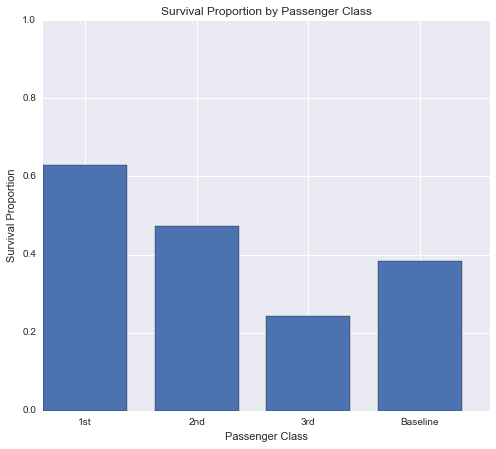

In [12]:
pclass_groups = titanic.groupby('Pclass')['Survived']
print(survival_rate_and_total(pclass_groups))

# Append the baseline_survival rate to the means list for plotting
means_by_pclass = pclass_groups.mean()
means_by_pclass = means_by_pclass.append(pd.Series([baseline_survival]))

# Prepare parameters for plotting
N = len(means_by_pclass) 
fig, ax = plt.subplots()

bar_width = 0.75
left_locs = np.arange(N)

ax.bar(left_locs, means_by_pclass, bar_width)

ax.set_ylabel('Survival Proportion')
ax.set_xlabel('Passenger Class')
ax.set_title('Survival Proportion by Passenger Class')
ax.set_xticks(left_locs + bar_width/2)
ax.set_xticklabels(('1st', '2nd', '3rd', 'Baseline'))
silent = plt.ylim([0,1])

These means all seem to differ from the baseline survival rate. Are the differences statistically significant? We can use a Chi-Square test to find out.

In [13]:
calculate_and_print_chisquared('Pclass', [1,2,3])

The P value for the chi-squared test comparing survival rates for Pclass is 1.71269559905e-14 .


Thus the mean survival rate in the groups is significantly different from the overall survival rate. We can do a post-hoc analysis to determine where the differences lie between each group.

In [14]:
calculate_and_print_pairwise_chisquared('Pclass', [1,2,3])

The P value for the chi-squared test comparing survival rates for values 1 and 2 for Pclass is 7.86700532232e-10 .
The P value for the chi-squared test comparing survival rates for values 1 and 3 for Pclass is 1.16222320434e-14 .
The P value for the chi-squared test comparing survival rates for values 2 and 3 for Pclass is 5.8894798869e-08 .
The alpha level for these tests is 0.016666666666666666 .


We can conclude that each group is significantly different from each other. This suggests that being in a higher class offered a better chance of survival. What story does this tell? Perhaps the better passenger classes were given priority on the limited lifeboats, or perhaps the way rooms were distributed around the boat put the more expensive rooms closer to lifeboats.

### Gender and Age

Similar to what we did with passenger class, we'll first look at the differences in survival rate by gender. 

In [15]:
calculate_and_print_chisquared('Sex',['male', 'female'])

The P value for the chi-squared test comparing survival rates for Sex is 3.97051638966e-37 .


We see a highly significant difference in the survival rate of males and females. As printed above, the female survival rate was much higher than the male survival rate.

Let's look closer at age. (Note that since we're looking at age, we'll shift to using the dataframe without missing values for age.) First, what does the distribution of ages look like in the dataset?

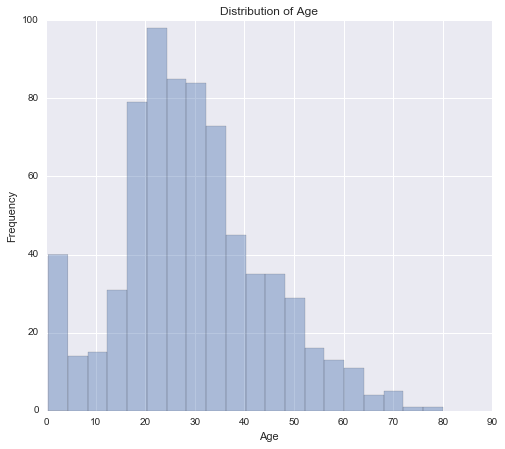

In [16]:
silent = sns.distplot(titanic_safe['Age'], kde = False).set(ylabel = 'Frequency', title = 'Distribution of Age')

This looks approximately normal, except with a higher proportion falling in the first ranges of ages from about 0-5 and with a long tail to the right. Let's get a picture of the difference in survival.

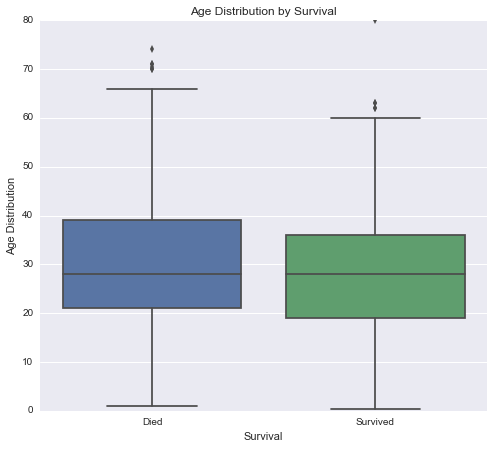

In [17]:
p = sns.boxplot(data = titanic_safe, x = 'Survived', y = 'Age')
silent = p.set(title = 'Age Distribution by Survival', 
        xlabel = 'Survival', 
        ylabel = 'Age Distribution', 
        xticklabels = ['Died', 'Survived'])

The survival rates don't actually look that different. However, our understanding of the shipwreck from popular culture is that children were given preference for survival. Perhaps the long right tail we saw in the distribution of the ages is skewing the results, there are way more adults in the dataset than children. Let's define "child" as anyone under 18 and group the data by the rule and then look at survival rate.

In [18]:
# Group in titanic by using a mapping function on age which assigns people to either the under 18 or over 18 group
def assign_age_group(x):
    return "Under_18" if titanic_safe['Age'].loc[x] < 18 else "Over_18"

age_groups = titanic_safe.groupby(assign_age_group)['Survived']
print(survival_rate_and_total(age_groups))

          % Survived of Total  Total
Over_18              0.381032    601
Under_18             0.539823    113


This does look like a difference of survival rates. Let's add a column to denote whether a person is under 18 and test for significance. 

In [19]:
titanic_safe.loc[:,'Under_18'] = titanic_safe['Age'] < 18
calculate_and_print_chisquared('Under_18', [True, False], df=titanic_safe)

The P value for the chi-squared test comparing survival rates for Under_18 is 0.00739135434657 .


We have a significant difference of survival for those under 18 and those over 18. Since we know gender is significant, could some of this difference be explained by different counts of gender for those under or over 18?

In [20]:
pd.crosstab(titanic_safe['Sex'], titanic_safe['Under_18'])

Under_18,False,True
Sex,,
female,206,55
male,395,58


While the under 18 counts are similar, there's almost double the amount of males in the over 18 group. This means that some of the variation in the survival rate could be due the different gender proportions of the groups.

We have a little bit more of the story taken from the individual analyses. The higher survival rate of females suggests that women and girls were given priority in boarding lifeboats. And similarly, the higher survival rates of the under 18 group suggests that children were given priority in boarding lifeboats.

What if we look a little bit closer at gender and age together? Were girls more likely to survive than boys and women more likely than men? This will go some way in determining whether the difference observed for children and adults above was simply due to the different proportions of the groups.

                 % Survived of Total  Total
         Sex                               
Over_18  female             0.771845    206
         male               0.177215    395
Under_18 female             0.690909     55
         male               0.396552     58


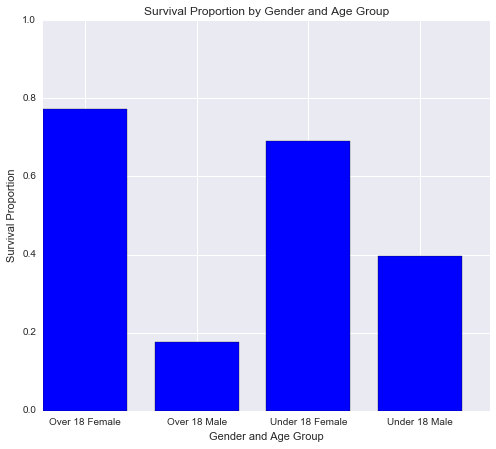

In [21]:
# Group by the previous mapping function and also by the Sex column
gender_age_groups = titanic_safe.groupby([assign_age_group, 'Sex'])['Survived']
print(survival_rate_and_total(gender_age_groups))

# Prepare plotting parameters
means_by_gender_age = gender_age_groups.mean()

N = len(means_by_gender_age) 
fig, ax = plt.subplots()

bar_width = 0.75
left_locs = np.arange(N)

ax.bar(left_locs, means_by_gender_age, bar_width, label='Survived', color='blue')

ax.set_ylabel('Survival Proportion')
ax.set_xlabel('Gender and Age Group')
ax.set_title('Survival Proportion by Gender and Age Group')
ax.set_xticks(left_locs + bar_width/2)
silent = ax.set_xticklabels(('Over 18 Female', 'Over 18 Male', 'Under 18 Female', 'Under 18 Male'))
silent = plt.ylim([0,1])

Tentatively it looks like women and girls had about the same survival rate, which were both better than boys and men, while boys had better survival rates than men. Let's put it to the test. We'll first add a new column which represents the gender and under 18 pair and then run the test using that new column.

In [22]:
# Takes a row from the data frame and returns a string representing it's sex and age group pair
def sex_age_pair(row):
    if row['Sex'] == 'male' and row['Age'] < 18:
        return "Male Child"
    elif row['Sex'] == 'male' and row['Age'] >= 18:
        return "Male Adult"
    elif row['Sex'] == 'female' and row['Age'] < 18:
        return "Female Child"
    else:
        return "Female Adult"

# Apply the function to each row and assign the result to a new column in titanic
titanic_safe.loc[:,'sex_age_pair'] = titanic_safe.apply(lambda x: sex_age_pair(x), axis=1)

calculate_and_print_chisquared('sex_age_pair',['Male Child', 'Male Adult', 'Female Child', 'Female Adult'],titanic_safe)

The P value for the chi-squared test comparing survival rates for sex_age_pair is 8.93374432915e-30 .


We have a significant difference for the groups. Let's do a pairwise comparison.

In [23]:
calculate_and_print_pairwise_chisquared('sex_age_pair', ['Male Child', 'Male Adult', 'Female Child', 'Female Adult'],titanic_safe)

The P value for the chi-squared test comparing survival rates for values Male Child and Male Adult for sex_age_pair is 3.35320225606e-11 .
The P value for the chi-squared test comparing survival rates for values Male Child and Female Child for sex_age_pair is 0.000234088755064 .
The P value for the chi-squared test comparing survival rates for values Male Child and Female Adult for sex_age_pair is 2.47039752325e-19 .
The P value for the chi-squared test comparing survival rates for values Male Adult and Female Child for sex_age_pair is 3.47435162246e-14 .
The P value for the chi-squared test comparing survival rates for values Male Adult and Female Adult for sex_age_pair is 5.82594947999e-29 .
The P value for the chi-squared test comparing survival rates for values Female Child and Female Adult for sex_age_pair is 2.70013965825e-22 .
The alpha level for these tests is 0.008333333333333333 .


These results suggest that indeed women, girls, and boys survived at different rates from men, and further that girls had better survival rates than boys. This suggests that women and girls were given the highest priority, followed by boys and then finally by men.

### Gender, Age, and Passenger Class

Finally, let's see if we can find any significant differences if we group the data by all three variables. This will help get us a more nuanced picture. Perhaps we only saw the difference in survival for different passenger classes because of different demographics. However, since we're breaking the data apart so much, we'll have to be more careful about what conclusions we draw. Our sample sizes will be much smaller in some groups particularly in the under 18 group in the 1st passenger class.

We'll plot a bar graph of the different survival rates.

                        % Survived of Total  Total
Pclass          Sex                               
1      Over_18  female             0.974026     77
                male               0.371134     97
       Under_18 female             0.875000      8
                male               1.000000      4
2      Over_18  female             0.903226     62
                male               0.068182     88
       Under_18 female             1.000000     12
                male               0.818182     11
3      Over_18  female             0.417910     67
                male               0.133333    210
       Under_18 female             0.542857     35
                male               0.232558     43


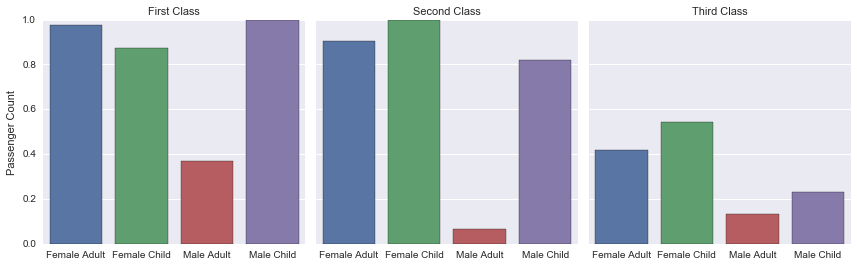

In [24]:
# Group by apply the mapping function for age as before, along with Pclass and Sex
gender_age_pclass_group = titanic_safe.groupby(['Pclass', assign_age_group, 'Sex'])['Survived']
print(survival_rate_and_total(gender_age_pclass_group))

titanic_safe = titanic_safe.rename(columns={'sex_age_pair':'Sex and Age'})
titanic_safe.loc[:, "Passenger Class"] = titanic_safe['Pclass'].map({1:'First Class', 2:'Second Class', 3:'Third Class'})
t = titanic_safe.groupby(['Passenger Class', 'Sex and Age'], as_index = False)['Survived'].mean()
p = sns.factorplot(data = t, x = 'Sex and Age', y = 'Survived', col = 'Passenger Class', kind = 'bar')
silent = (p.set_axis_labels('', 'Passenger Count').set_titles('{col_name}'))

Both 1st and 2nd passenger class look very similar, but 3rd stands out as being lower across each sex and age pair, except possibly for over 18 males. The proportion of adult males who survived in first class looks to be a lot higher than in the other two classes as well.

If we wanted to test for significance, we can't use the chi-square due to some groups having small sample sizes. We'll leave it at speculation for this section.

## Conclusion

The data seems to corroborate the story of the Titanic shipwreck that we've heard in popular culture. Women and children seem like they were given preference over males. However, it has also revealed where that story is more nuanced. Even comparing young girls and boys, it looks like girls had a higher chance to survive. And being in 3rd class meant a worse chance for survival.